ACCIDENT DETECTION PROJECT BY GNANU



MobileNetV2 model loaded successfully.
Images extracted successfully from ZIP file.
Train and test directories already exist. Skipping classification.
Images moved to validation directory successfully.
Found 989 images belonging to 1 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Data generators created successfully.
30/30 [==============================] - 212s 6s/step - loss: 0.0266 - accuracy: 0.9969
Model trained successfully.
Error evaluating the model on test data: Asked to retrieve element 0, but the Sequence has length 0
1/1 [==============================] - 1s 943ms/step
Accident Detected!
Camera location not recognized. Selecting random location.
Randomly Selected Camera Location: c2
Nearby Hospitals:
   Hospital Contact No.
RK Hospital    70009000
       KIMS    68000000


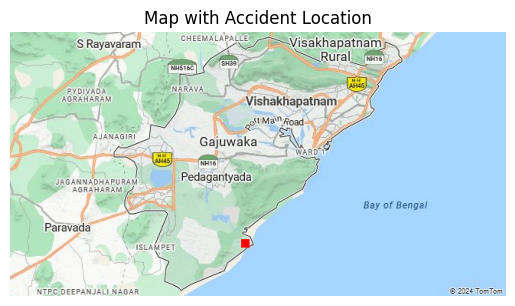

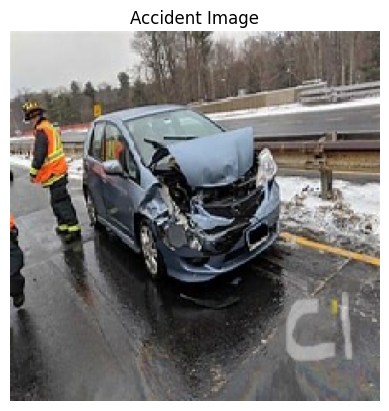

In [9]:
import os
import zipfile
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

# Function to extract images from a ZIP file
def extract_images_from_zip(zip_path, extract_path):
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Images extracted successfully from ZIP file.")
    except Exception as e:
        print("Error extracting images from ZIP file:", e)

# Function to classify images into train, test, and validation sets
def classify_images(extract_path, train_ratio=0.8, test_ratio=0.1):
    try:
        images_dir = os.listdir(extract_path)
        train_dir = os.path.join(extract_path, 'train')
        test_dir = os.path.join(extract_path, 'test')
        val_dir = os.path.join(extract_path, 'val')

        # Create directories for train, test, and validation sets if they don't exist
        if not os.path.exists(train_dir):
            os.makedirs(train_dir)
        if not os.path.exists(test_dir):
            os.makedirs(test_dir)
        if not os.path.exists(val_dir):
            os.makedirs(val_dir)

        for image_file in images_dir:
            # Split images into train, test, and validation sets based on ratios
            rand = np.random.rand()
            if rand < train_ratio:
                dest_dir = train_dir
            elif rand < train_ratio + test_ratio:
                dest_dir = test_dir
            else:
                dest_dir = val_dir

            dest_file = os.path.join(dest_dir, image_file)
            if not os.path.exists(dest_file):
                shutil.move(os.path.join(extract_path, image_file), dest_file)
        print("Images classified successfully.")
    except Exception as e:
        print("Error classifying images:", e)

# Load the pre-trained MobileNetV2 model
try:
    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False)
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print("MobileNetV2 model loaded successfully.")
except Exception as e:
    print("Error loading MobileNetV2 model:", e)

# Extract and classify images
zip_path = '/content/drive/MyDrive/accident.zip'  # Path to the ZIP file
extract_path = '/content/extracted_images'  # Directory to extract images
extract_images_from_zip(zip_path, extract_path)

# Check if train and test directories exist and classify images if necessary
def check_and_classify_images(extract_path):
    try:
        train_dir = os.path.join(extract_path, 'train')
        test_dir = os.path.join(extract_path, 'test')

        if not os.path.exists(train_dir) or not os.path.exists(test_dir):
            print("Train and test directories not found. Classifying images...")
            classify_images(extract_path)
        else:
            print("Train and test directories already exist. Skipping classification.")
    except Exception as e:
        print("Error checking and classifying images:", e)

check_and_classify_images(extract_path)

# Ensure that the validation directory exists and contains images
val_dir = '/content/extracted_images/val'
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

# Function to move a percentage of images from train directory to validation directory
def move_images_to_val(train_dir, val_dir, val_ratio=0.1):
    try:
        for class_name in os.listdir(train_dir):
            class_dir = os.path.join(train_dir, class_name)
            images = os.listdir(class_dir)
            num_val_images = int(val_ratio * len(images))
            val_images = np.random.choice(images, num_val_images, replace=False)
            for image in val_images:
                src = os.path.join(class_dir, image)
                dst = os.path.join(val_dir, class_name, image)
                os.makedirs(os.path.dirname(dst), exist_ok=True)
                shutil.move(src, dst)
        print("Images moved to validation directory successfully.")
    except Exception as e:
        print("Error moving images to validation directory:", e)

# Move a percentage of images from train directory to validation directory
train_dir = '/content/extracted_images/train'
val_dir = '/content/extracted_images/val'
move_images_to_val(train_dir, val_dir)

# Data preprocessing and augmentation
try:
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    test_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)

    # Data generators
    batch_size = 32
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary'
    )
    test_generator = test_datagen.flow_from_directory(
        '/content/extracted_images/test',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary'
    )
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary'
    )
    print("Data generators created successfully.")
except Exception as e:
    print("Error creating data generators:", e)

# Train the model with one epoch
try:
    model.fit(
        train_generator,
        steps_per_epoch=train_generator.n // batch_size,
        epochs=1,
        validation_data=val_generator,
        validation_steps=val_generator.n // batch_size
    )
    print("Model trained successfully.")
except Exception as e:
    print("Error training the model:", e)

# Evaluate the model on test data
try:
    loss, accuracy = model.evaluate(test_generator)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)
except Exception as e:
    print("Error evaluating the model on test data:", e)

# Function to generate random location
def generate_random_location(map_image):
    map_width, map_height = map_image.size
    return random.randint(0, map_width), random.randint(0, map_height)

# Function to mark a location on the map image
def mark_location_on_map(map_image, location):
    draw = ImageDraw.Draw(map_image)
    draw.rectangle([location[0]-5, location[1]-5, location[0]+5, location[1]+5], fill="red")
    return map_image

# Function to generate random nearby hospital
def generate_random_hospital(location):
    hospitals = {
        "c1": [("Government Hospital", "90000000"), ("Amma Hospital", "880900900")],
        "c2": [("RK Hospital", "70009000"), ("KIMS", "68000000")],
        "c3": [("Care Hospital", "8650000")]
    }
    location_info = hospitals.get(location.lower(), [])
    return location_info

# Predict accidents in the provided image
given_image_path = '/content/add.jpeg'  # Path to the image to be predicted
if os.path.exists(given_image_path):
    try:
        # Load the image
        img = tf.keras.preprocessing.image.load_img(given_image_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, axis=0)
        img_array /= 255.0

        # Predict using the model
        prediction = model.predict(img_array)
        accident_detected = prediction[0][0] > 0.5

        # Get camera location from image labels
        labels = ["c1", "c2", "c3"]  # Define possible camera locations
        camera_location = None
        for label in labels:
            if label in given_image_path.lower():
                camera_location = label
                break

        if accident_detected:
            print("\033[1m\033[91mAccident Detected!\033[0m")
            if camera_location:
                print("\033[1mCamera Location:\033[0m", camera_location)
                hospitals_info = generate_random_hospital(camera_location)
                if hospitals_info:
                    print("\033[1mNearby Hospitals:\033[0m")
                    df = pd.DataFrame(hospitals_info, columns=["Hospital", "Contact No."])
                    print(df.to_string(index=False))
                else:
                    print("No nearby hospitals information available.")
            else:
                print("\033[1mCamera location not recognized. Selecting random location.\033[0m")
                camera_location = random.choice(labels)
                print("\033[1mRandomly Selected Camera Location:\033[0m", camera_location)
                hospitals_info = generate_random_hospital(camera_location)
                if hospitals_info:
                    print("\033[1mNearby Hospitals:\033[0m")
                    df = pd.DataFrame(hospitals_info, columns=["Hospital", "Contact No."])
                    print(df.to_string(index=False))
                else:
                    print("No nearby hospitals information available.")

            # Load the map image
            map_image = Image.open('/content/map.jpeg')  # Path to the map image
            # Generate random location on the map
            accident_location = generate_random_location(map_image)
            # Mark accident location on map image
            marked_map_image = mark_location_on_map(map_image.copy(), accident_location)
            # Display the marked map image
            plt.imshow(marked_map_image)
            plt.title('Map with Accident Location')
            plt.axis('off')
            plt.show()

            # Display the accident image
            plt.imshow(img)
            plt.title('Accident Image')
            plt.axis('off')
            plt.show()
        else:
            print("No accident detected.")
    except Exception as e:
        print("Error predicting on the provided image:", e)
else:
    print("Given image file not found.")
